## Purpose of the Project:
It can be trying to detect the relationship between gene and gene and mutations. But first of all, we will give an overview of the variants table as it would be more useful to analyze the tables within themselves.Since the aim of the project is to make a classification according to genes and mutations, there are 9 different classes that we understand from the variants table and this classification is made according to the gene-variation-text relationship. We need to examine the correlations of these columns within themselves, but both the gene and mutation columns contain categorical data. Of course, the text column is categorical, but since NLP technique will be used for it, we will evaluate it separately. Our first goal at the moment is to make Gen and Mutation columns understandable to Machine Learning algorithms. For this, let's examine the variations table in more detail.

##  Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re #Regular expression
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import time
import warnings
#import nltk
#from nltk.corpus import stopwords
from collections import Counter, defaultdict
from sklearn.preprocessing import normalize
from sklearn import metrics# Import the model we are using
from sklearn.ensemble import RandomForestRegressor# Instantiate model with 1000 decision trees
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

C:\Users\Toshiba\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Reading Traing and test data from files

In [4]:
data_variants = pd.read_csv('training_variants')
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

data_variants.head(3)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


In [3]:
print("Data Variant".ljust(15), data_variants.shape)
print("Data Text".ljust(15),data_text.shape)
print("Test Variant".ljust(15), test_variants.shape)
print("Test Text".ljust(15), test_text.shape)
data_variants.head()

Data Variant    (3321, 4)
Data Text       (3321, 2)
Test Variant    (5668, 3)
Test Text       (5668, 2)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


## Singularity check for each Column

In [10]:
print("Number of Unique ID", len(data_variants.ID.unique()))
print("Number of unique genes: ", len(data_variants.Gene.unique()))
print("Number of unique variations: ", len(data_variants.Variation.unique()))
print( "classes:",len(data_variants.Class.unique()) )
print("Number of unique text: ", len(data_text.TEXT.unique()))

Number of Unique ID 3321
Number of unique genes:  264
Number of unique variations:  2996
classes: 9
Number of unique text:  1921


In [4]:
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [41]:
#Checking Information
data_variants.info()
# Checking dimention of data
data_variants.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   object
dtypes: int64(1), object(3)
memory usage: 103.9+ KB


(3321, 4)

## Text PreProcessing

In [9]:
stopwords=['a','about','activity','mutations','cells','cancers','above','analysis','activation','patients','patient',
'protein','proteins','role','identified','figure','after','again','against','previously','ain','all','am','an','and',
 'any','are','aren',"aren't",'as','at','be','because','been','before','being','below','between','both','but','by',
 'cell','cells','can','couldn',"couldn't",'experiments','fig', 'd','did','didn',"didn't",'do','does','doesn',"doesn't",
 'doing','don', "don't",'down','domain','during','each','few', 'for','from','further','had','hadn',"hadn't",
 'has','hasn',"hasn't",'have','haven',"haven't",'having','he','her','here','hers','herself','him','himself','his',
 'how','hotspot','human','i','if','in','into','inhibitors','is','isn',"isn't",'it',"it's",'its','itself','just',
 'll','methods','method','m','ma','me','mightn',"mightn't",'more','most','mustn',"mustn't",'my','myself',
 'needn',"needn't",'no', 'nor', 'not','now', 'o','associated','described', 'of','off', 'on','once','only',
 'or','other','our','ours','ourselves','out', 'over','figure','patients', 'own','re', 's', 'same', 'shan', "shan't",
 'she',"she's",'should',"should've", 'shouldn', "shouldn't", 'so', 'some', 'such','t','than','that', "that'll", 'the',
 'their','theirs','them', 'themselves','then', 'there','these','they', 'this','those','through','to',
 'too','types', 'under', 'until', 'protein', 'expression', 'up','variants', 've', 'very','was','wasn', "wasn't",
 'we','were','weren',"weren't",'what','when','where','which','while','who','whom', 'why', 'will','with',
 'won',"won't",'wouldn',"wouldn't",'expression','data','human','activity', 'y','you',"you'd","you'll","you're", "you've",
 'your', 'yours', 'yourself', 'yourselves','years','populations','1995']

def data_text_preprocess(total_text, ind, col):
    # Remove int values from text data as that might not be imp
    if type(total_text) is not int:
        string = ""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bring whole text to same lower-case scale.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if  (word not in stopwords and len(word)>2):
            #if len(word)>3 and word:
                string += str(word) + " "
        
        data_text[col][ind] = string

In [10]:
#Text Preprocessing
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

C:\Users\my pc\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Merging both gene_variations and text data based on ID

In [11]:
#merging both gene_variations and text data based on ID
def Merge_DF(maindf,seconddf):
    Data_full = pd.merge(maindf, seconddf,on='ID', how='left')
    return Data_full
    
Data_full=Merge_DF(data_variants,data_text)   
print(Data_full)

        ID    Gene             Variation  Class  \
0        0  FAM58A  Truncating Mutations      1   
1        1     CBL                 W802*      2   
2        2     CBL                 Q249E      2   
3        3     CBL                 N454D      3   
4        4     CBL                 L399V      4   
...    ...     ...                   ...    ...   
3316  3316   RUNX1                 D171N      4   
3317  3317   RUNX1                 A122*      1   
3318  3318   RUNX1               Fusions      1   
3319  3319   RUNX1                  R80C      4   
3320  3320   RUNX1                  K83E      4   

                                                   TEXT  
0     cyclin dependent kinases cdks regulate variety...  
1     abstract background non small lung cancer nscl...  
2     abstract background non small lung cancer nscl...  
3     recent evidence demonstrated acquired uniparen...  
4     oncogenic monomeric casitas lineage lymphoma c...  
...                                    

## Null Control 

In [457]:
def Null_Control(df):
       return df[df.isnull().any(axis=1)]
    
Null_Control(Data_full) #Null Control For Full Data  (Text Side)

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [19]:
y_true = Data_full['Class'].values
Data_full.Gene      = Data_full.Gene.str.replace('\s+', '_')
Data_full.Variation = Data_full.Variation.str.replace('\s+', '_')

## 1. Evaluating Gen Column 

## 1.1 Distribution of Gene Mutation on Each Class

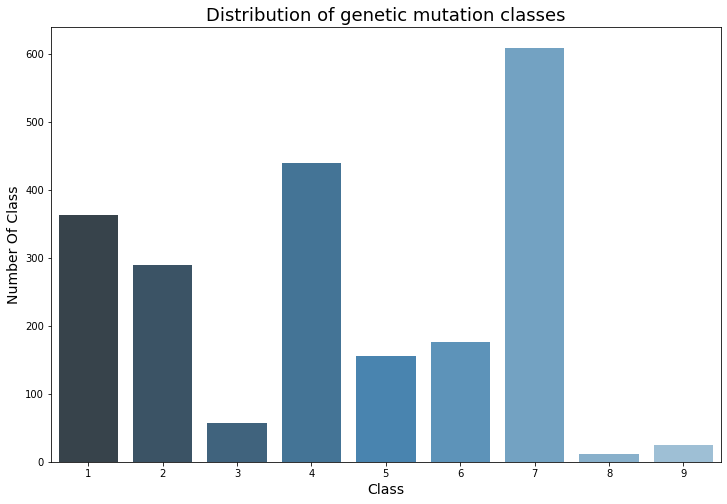

In [22]:
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=Data_full, palette="Blues_d")
plt.ylabel('Number Of Class', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Distribution of genetic mutation classes", fontsize=18)
plt.show()
#

In [26]:
print("\nGenes with minimal occurences\n", minimal_occ_genes)


Genes with minimal occurences
 Gene
LATS1    1
NCOR1    1
MYOD1    1
MEN1     1
MDM2     1
MAPK1    1
KMT2D    1
KMT2B    1
KLF4     1
IL7R     1
Name: Gene, dtype: int64


## 1.2 Graphical Display of the Top 7 Genes in each Class

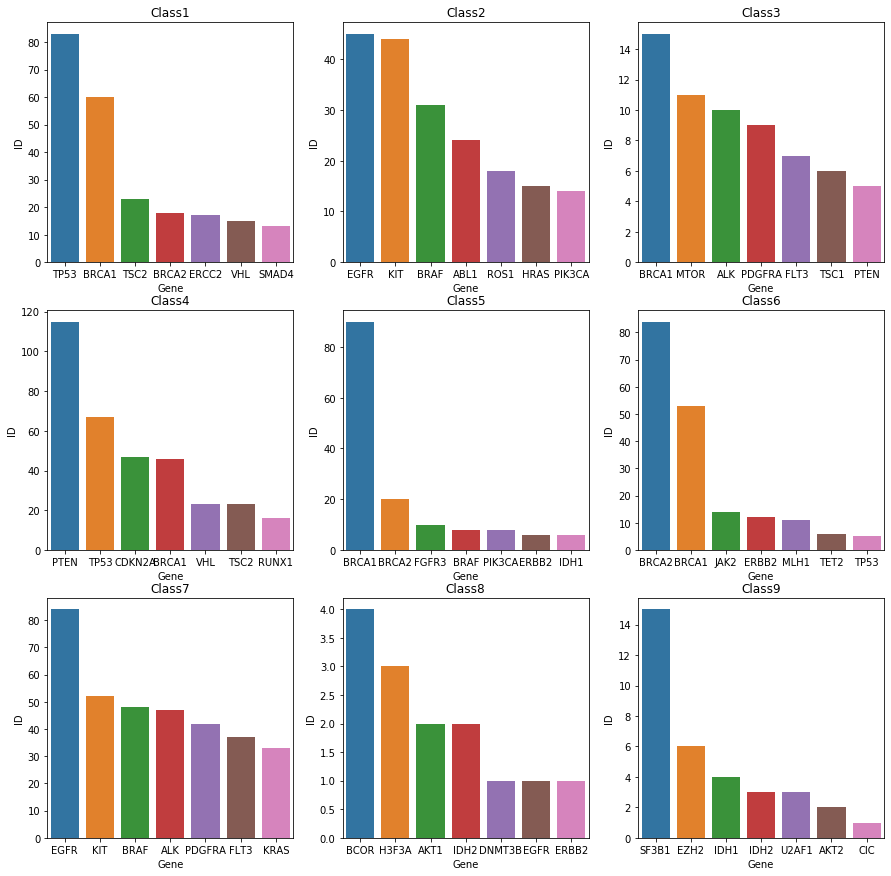

In [16]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))
#Graphical Display of the Top 7 Genes in each Class

for i in range(3):
    for j in range(3):
        gene_count_grp = Data_full[Data_full["Class"]==((i*3+j)+1)].groupby('Gene')["ID"].count().reset_index()
        max_occurence_gen=gene_count_grp.sort_values('ID', ascending=False)
        sorted_gene_group_top_7 = max_occurence_gen[:7]
        ax=sns.barplot(x="Gene", y="ID", data=sorted_gene_group_top_7, ax=axs[i][j])

        z=(i*3+j)+1
        ax.set(title ="Class"+str(z))
        # For Class 1 TP53 gene dominant
        # For Class 2 EGFR gene dominant
        # For Class 3 BRCA1 gene dominant
        # For Class 7 EGFR gene dominant


In [11]:
Data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ID           3321 non-null   int64   
 1   Gene         3321 non-null   object  
 2   Variation    3321 non-null   object  
 3   Class        3321 non-null   int64   
 4   TEXT         3316 non-null   object  
 5   categorical  3321 non-null   category
dtypes: category(1), int64(2), object(3)
memory usage: 174.2+ KB


## 1.3 Distribution of Classes to Records

In [33]:
for i in range(1,10):
    df=Data_full[Data_full.Class==i]
    print("Class=",i,"and shape=",df.shape)
    

Class= 1 and shape= (568, 6)
Class= 2 and shape= (452, 6)
Class= 3 and shape= (89, 6)
Class= 4 and shape= (686, 6)
Class= 5 and shape= (242, 6)
Class= 6 and shape= (275, 6)
Class= 7 and shape= (953, 6)
Class= 8 and shape= (19, 6)
Class= 9 and shape= (37, 6)


## 1.4 Number of Unique Genes

In [29]:
unique_genes = Data_full['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 264
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ALK        69
ERBB2      69
PDGFRA     60
Name: Gene, dtype: int64


## 1.5 Cumulative Gen Distribution

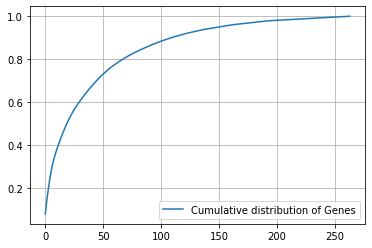

In [17]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

The chart above answers the question of how many genes make up our data set.For this, we used the mathematical formula of cumulative distribution. For example, 75% of our data set constituted only 50 genes from 264 genes. We could do the same for Class attribute, but we didn't do it because it was easy to select by staring. This function was a good way for cases where there are many categories such as gene columns.


## 1.6 Method 1: One hot encoding Method for Gene column

In [180]:
Data_full['categorical'] = pd.Categorical(Data_full['Gene'])
dfGenes = pd.get_dummies(Data_full['categorical'], prefix = 'Var')
dfGenes

,Var_ABL1,Var_ACVR1,Var_AGO2,Var_AKT1,Var_AKT2,Var_AKT3,Var_ALK,Var_APC,Var_AR,Var_ARAF,...,Var_TSC1,Var_TSC2,Var_U2AF1,Var_VEGFA,Var_VHL,Var_WHSC1,Var_WHSC1L1,Var_XPO1,Var_XRCC2,Var_YAP1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3318,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3319,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As understood above, this method is insufficient for the other two categorical data because it is necessary to create too many columns. Mutations are too many, and we should probably make a distribution of which genes they are forming.
But what method should we analyze the column of genes?
How easy is it to find how many genes are in each class?
Perhaps there is an accumulation in a class. It may be good to observe this too.

The number of lines entering Class 1 is 568.
Number of lines entering Class 2 452
The maximum number of lines belongs to class 7.

The distribution was as above.
We have previously demonstrated that there are 264 different Genes. Now we will examine their distributions.

We decided to use the Response Encoding method for the Gene column. How easy is this method to find out how many genes there are in each class we mentioned above? When we set out from the question, it was a method that we encountered. Response Encoding bize olasılıksal olarak verilen her genin sınıflar üzerindeki dağılımlarını içeren bir yöntemdir. Basically includes Bayes Theory. P(class=X | gene=A) = P(gene=A ∩ class=X) / P(gene=A) will be used. In our columns, it will be State_0 State_1 State_3 .. and each line will contain probabilistic distributions of a gene on those classes. So since we have 264 genes, we should get a table with 264 lines.


In [17]:
# gv_dict : Gene Variation Dictionary, which contains the probability array for each gene
gv_dict = dict()
    
value_count = Data_full['Gene'].value_counts()
value_count

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
CDK8        1
RICTOR      1
FLT1        1
INPP4B      1
DUSP4       1
Name: Gene, Length: 264, dtype: int64

## Train Test Splitting

In [47]:
y_true = Data_full['Class'].values
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(Data_full, y_true, stratify=y_true, test_size=0.2)
# split the train data now into train validation and cross validation
#train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [238]:
print('Number of data points in X train data:', X_train.shape[0])
print('Number of data points in Y train data:', y_train.shape[0])
print('Number of data points in X test data:', test_df.shape[0])
print('Number of data points in Y test data:', y_test.shape[0])

Number of data points in X train data: 2656
Number of data points in Y train data: 2656
Number of data points in X test data: 665
Number of data points in Y test data: 665


##  Response Encoding Function

In [43]:
def get_gv_fea_dict(feature,df):
    gv_dict = dict()
    value_count = df[feature].value_counts()
    #denominator her genin datada kaç kez oluştuğunu göstermektedir. Örneğin BRCA1 datada 264 kez vardır.
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = df.loc[(df['Class']==k) & (df[feature]==i)]
            vec.append((cls_cnt.shape[0] + 0.001*10)/ (denominator + 0.001*90))
        gv_dict[i]=vec
    return gv_dict

## 1.6  Method 2:  Response Encoding Function For Gen As Full DataFrame

The aim is to find the appearing ratios of each gene and variation for each class.

For example; BRCA1 gene has 264 in total. Whether there are 50 in Class 1, the ratio for Class1 is 50/264. Get 70 in Class 2. It would be 70/264.

In [100]:
#For Gene
gene_responseCoding = pd.DataFrame(get_gv_fea_dict("Gene",Data_full))
#Right now, every gene has possibilities on classes.
gene_responseCoding

,BRCA1,TP53,EGFR,PTEN,BRCA2,KIT,BRAF,ALK,ERBB2,PDGFRA,...,RNF43,EPCAM,SHOC2,RAD51B,PIK3R3,RRAS2,GLI1,BARD1,PMS1,BCL2
0,0.227233,0.508983,0.007159,0.023872,0.143976,0.000101,0.000107,0.000145,0.014619,0.016808,...,0.926606,0.009174,0.009174,0.009174,0.926606,0.009174,0.926606,0.926606,0.009174,0.009174
1,0.000038,0.018456,0.319016,0.000079,0.000080,0.444142,0.333118,0.101462,0.202779,0.050092,...,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174
2,0.056837,0.012324,0.007159,0.039734,0.000080,0.010193,0.010850,0.144883,0.000145,0.149942,...,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174
3,0.174221,0.410877,0.035509,0.912126,0.024063,0.010193,0.021592,0.000145,0.072514,0.016808,...,0.009174,0.926606,0.926606,0.009174,0.009174,0.009174,0.009174,0.009174,0.926606,0.009174
4,0.340831,0.012324,0.021334,0.015941,0.159965,0.000101,0.086046,0.072514,0.086988,0.066733,...,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174
5,0.200727,0.030719,0.007159,0.000079,0.671596,0.010193,0.032334,0.000145,0.173831,0.000166,...,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174
6,0.000038,0.000061,0.595436,0.008010,0.000080,0.524876,0.515737,0.680417,0.434361,0.699118,...,0.009174,0.009174,0.009174,0.009174,0.009174,0.926606,0.009174,0.009174,0.009174,0.926606
7,0.000038,0.000061,0.007159,0.000079,0.000080,0.000101,0.000107,0.000145,0.014619,0.000166,...,0.009174,0.009174,0.009174,0.926606,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174
8,0.000038,0.006193,0.000071,0.000079,0.000080,0.000101,0.000107,0.000145,0.000145,0.000166,...,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174


##  1.6 Method 2: Probability in each class for the relevant feature in each line

According to the gene value in each line, whatever the probabilities of that gene are, they are found in gen_responseCoding and the probabilities of the related gene belonging to 9 different classes are added as a new column. For example, if there is a CBL gene in line 1, the probability of CBL gene in 9 classes is calculated.

In [101]:
def find_prob_class(type_responseCoding,df,feature,class_name):
    k=0
    for value in df[feature]:
        for col in type_responseCoding.columns: 
            i=0
            for i in range(0,9):
                Class_name_join=str(class_name)+str(i+1)
                if value==col:
                    df.loc[k,Class_name_join]=type_responseCoding[value][i]
        k+=1
    return df

In [102]:
Data_full=find_prob_class(gene_responseCoding,Data_full,"Gene","Gen_Prob_Of_Class")
Data_full

,ID,Gene,Variation,Class,TEXT,Gen_Prob_Of_Class1,Gen_Prob_Of_Class2,Gen_Prob_Of_Class3,Gen_Prob_Of_Class4,Gen_Prob_Of_Class5,...,Variation_Prob_Of_Class9,TEXT_Prob_Of_Class1,TEXT_Prob_Of_Class2,TEXT_Prob_Of_Class3,TEXT_Prob_Of_Class4,TEXT_Prob_Of_Class5,TEXT_Prob_Of_Class6,TEXT_Prob_Of_Class7,TEXT_Prob_Of_Class8,TEXT_Prob_Of_Class9
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...,0.926606,0.009174,0.009174,0.009174,0.009174,...,0.000107,0.926606,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174
1,1,CBL,W802*,2,abstract background non small lung cancer nscl...,0.080112,0.080112,0.040255,0.638103,0.119968,...,0.009174,0.004785,0.961722,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785
2,2,CBL,Q249E,2,abstract background non small lung cancer nscl...,0.080112,0.080112,0.040255,0.638103,0.119968,...,0.009174,0.004785,0.961722,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...,0.080112,0.080112,0.040255,0.638103,0.119968,...,0.009174,0.002445,0.002445,0.246944,0.735941,0.002445,0.002445,0.002445,0.002445,0.002445
4,4,CBL,L399V,4,oncogenic monomeric casitas lineage lymphoma c...,0.080112,0.080112,0.040255,0.638103,0.119968,...,0.009174,0.001236,0.001236,0.001236,0.619283,0.372064,0.001236,0.001236,0.001236,0.001236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,introduction myelodysplastic syndromes mds het...,0.207970,0.000415,0.000415,0.664591,0.000415,...,0.009174,0.009174,0.009174,0.009174,0.926606,0.009174,0.009174,0.009174,0.009174,0.009174
3317,3317,RUNX1,A122*,1,introduction myelodysplastic syndromes mds het...,0.207970,0.000415,0.000415,0.664591,0.000415,...,0.009174,0.246944,0.002445,0.002445,0.735941,0.002445,0.002445,0.002445,0.002445,0.002445
3318,3318,RUNX1,Fusions,1,runt related transcription factor gene runx1 a...,0.207970,0.000415,0.000415,0.664591,0.000415,...,0.000293,0.926606,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174
3319,3319,RUNX1,R80C,4,runx1 aml1 gene frequent target chromosomal tr...,0.207970,0.000415,0.000415,0.664591,0.000415,...,0.009174,0.009174,0.009174,0.009174,0.926606,0.009174,0.009174,0.009174,0.009174,0.009174


In [106]:
Data_full

,ID,Gene,Variation,Class,TEXT,Gen_Prob_Of_Class1,Gen_Prob_Of_Class2,Gen_Prob_Of_Class3,Gen_Prob_Of_Class4,Gen_Prob_Of_Class5,...,Variation_Prob_Of_Class9,TEXT_Prob_Of_Class1,TEXT_Prob_Of_Class2,TEXT_Prob_Of_Class3,TEXT_Prob_Of_Class4,TEXT_Prob_Of_Class5,TEXT_Prob_Of_Class6,TEXT_Prob_Of_Class7,TEXT_Prob_Of_Class8,TEXT_Prob_Of_Class9
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...,0.926606,0.009174,0.009174,0.009174,0.009174,...,0.000107,0.926606,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174
1,1,CBL,W802*,2,abstract background non small lung cancer nscl...,0.080112,0.080112,0.040255,0.638103,0.119968,...,0.009174,0.004785,0.961722,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785
2,2,CBL,Q249E,2,abstract background non small lung cancer nscl...,0.080112,0.080112,0.040255,0.638103,0.119968,...,0.009174,0.004785,0.961722,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...,0.080112,0.080112,0.040255,0.638103,0.119968,...,0.009174,0.002445,0.002445,0.246944,0.735941,0.002445,0.002445,0.002445,0.002445,0.002445
4,4,CBL,L399V,4,oncogenic monomeric casitas lineage lymphoma c...,0.080112,0.080112,0.040255,0.638103,0.119968,...,0.009174,0.001236,0.001236,0.001236,0.619283,0.372064,0.001236,0.001236,0.001236,0.001236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,introduction myelodysplastic syndromes mds het...,0.207970,0.000415,0.000415,0.664591,0.000415,...,0.009174,0.009174,0.009174,0.009174,0.926606,0.009174,0.009174,0.009174,0.009174,0.009174
3317,3317,RUNX1,A122*,1,introduction myelodysplastic syndromes mds het...,0.207970,0.000415,0.000415,0.664591,0.000415,...,0.009174,0.246944,0.002445,0.002445,0.735941,0.002445,0.002445,0.002445,0.002445,0.002445
3318,3318,RUNX1,Fusions,1,runt related transcription factor gene runx1 a...,0.207970,0.000415,0.000415,0.664591,0.000415,...,0.000293,0.926606,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174
3319,3319,RUNX1,R80C,4,runx1 aml1 gene frequent target chromosomal tr...,0.207970,0.000415,0.000415,0.664591,0.000415,...,0.009174,0.009174,0.009174,0.009174,0.926606,0.009174,0.009174,0.009174,0.009174,0.009174


## 1.6 Method 3: Response Encoding For Gen As ..

In [48]:

# Get Gene variation feature
def get_gv_feature(feature, df):
    
    gv_dict = get_gv_fea_dict(feature, df)
    value_count = df[feature].value_counts()
    
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])

    return gv_fea

In [49]:
train_gene_responseCoding = np.array(get_gv_feature("Gene", X_train))
test_gene_responseCoding = np.array(get_gv_feature("Gene", test_df))


## 2. Evaluating Variation Column 

## 2.1 Distrubition Of Variations

In [15]:
unique_variations = Data_full['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 2996
Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
G12V                     4
T58I                     3
Q61L                     3
Q61H                     3
Q61R                     3
Name: Variation, dtype: int64


##  2.2 Cumulative Distrubitions for Variations

[0.02800361 0.05028606 0.07166516 ... 0.99939777 0.99969889 1.        ]


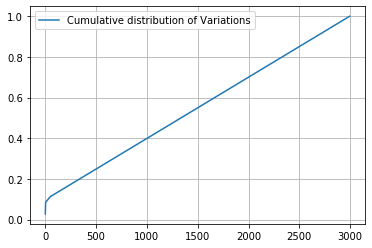

In [32]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

##  2.3 Method 1: One hot encoding Method for Variation  Column

In [83]:
Data_full['categorical'] = pd.Categorical(Data_full['Variation'])
dfVariation = pd.get_dummies(Data_full['categorical'], prefix = 'Var')
dfVariation

,Var_1_2009trunc,Var_2010_2471trunc,Var_256_286trunc,Var_3' Deletion,Var_385_418del,Var_422_605trunc,Var_533_534del,Var_534_536del,Var_550_592del,Var_560_561insER,...,Var_Y87N,Var_Y901C,Var_Y931C,Var_Y98H,Var_Y98N,Var_YAP1-FAM118B Fusion,Var_YAP1-MAMLD1 Fusion,Var_ZC3H7B-BCOR Fusion,Var_ZNF198-FGFR1 Fusion,Var_p61BRAF
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3318,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3319,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


2996 columns were formed for each variation. However, taking them as input reduces performance very much.
Therefore, we will look at the distribution of the data and use the Response Encoding method.

We observe that 2500 kinds of variation make up 80% of the data.

## 2.3 Method 2: Response Encoding For Variations As Ful Data Frame

In [1]:
#For variation
variation_responseCoding = pd.DataFrame(get_gv_fea_dict("Variation",Data_full))
#We now have possibilities for each variation on classes.
variation_responseCoding

NameError: name 'pd' is not defined

In [77]:
Data_full=find_prob_class(variation_responseCoding,Data_full,"Variation","Variation_Prob_Of_Class")
Data_full

,ID,Gene,Variation,Class,TEXT,Gen_Prob_Of_Class1,Gen_Prob_Of_Class2,Gen_Prob_Of_Class3,Gen_Prob_Of_Class4,Gen_Prob_Of_Class5,...,Variation_Prob_Of_Class9,TEXT_Prob_Of_Class1,TEXT_Prob_Of_Class2,TEXT_Prob_Of_Class3,TEXT_Prob_Of_Class4,TEXT_Prob_Of_Class5,TEXT_Prob_Of_Class6,TEXT_Prob_Of_Class7,TEXT_Prob_Of_Class8,TEXT_Prob_Of_Class9
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...,0.926606,0.009174,0.009174,0.009174,0.009174,...,0.000107,0.926606,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174
1,1,CBL,W802*,2,abstract background non small lung cancer nscl...,0.080112,0.080112,0.040255,0.638103,0.119968,...,0.009174,0.004785,0.961722,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785
2,2,CBL,Q249E,2,abstract background non small lung cancer nscl...,0.080112,0.080112,0.040255,0.638103,0.119968,...,0.009174,0.004785,0.961722,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...,0.080112,0.080112,0.040255,0.638103,0.119968,...,0.009174,0.002445,0.002445,0.246944,0.735941,0.002445,0.002445,0.002445,0.002445,0.002445
4,4,CBL,L399V,4,oncogenic monomeric casitas lineage lymphoma c...,0.080112,0.080112,0.040255,0.638103,0.119968,...,0.009174,0.001236,0.001236,0.001236,0.619283,0.372064,0.001236,0.001236,0.001236,0.001236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,introduction myelodysplastic syndromes mds het...,0.207970,0.000415,0.000415,0.664591,0.000415,...,0.009174,0.009174,0.009174,0.009174,0.926606,0.009174,0.009174,0.009174,0.009174,0.009174
3317,3317,RUNX1,A122*,1,introduction myelodysplastic syndromes mds het...,0.207970,0.000415,0.000415,0.664591,0.000415,...,0.009174,0.246944,0.002445,0.002445,0.735941,0.002445,0.002445,0.002445,0.002445,0.002445
3318,3318,RUNX1,Fusions,1,runt related transcription factor gene runx1 a...,0.207970,0.000415,0.000415,0.664591,0.000415,...,0.000293,0.926606,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174
3319,3319,RUNX1,R80C,4,runx1 aml1 gene frequent target chromosomal tr...,0.207970,0.000415,0.000415,0.664591,0.000415,...,0.009174,0.009174,0.009174,0.009174,0.926606,0.009174,0.009174,0.009174,0.009174,0.009174


## 2.3  Method 3:Response Encoding For Gen As ..

In [50]:
#For Variation
train_variation_responseCoding = np.array(get_gv_feature("Variation",X_train))
#We now have possibilities for each gene on classes.
test_variation_responseCoding = np.array(get_gv_feature("Variation", test_df))


Below, the probability of being in the Classes for the Variation in each line is calculated.

## Text Processing

## 3.1 Distribution of Text Length by Classes

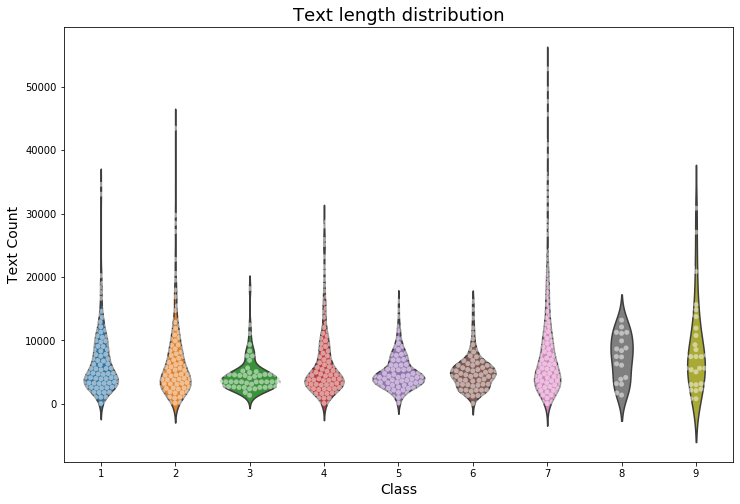

In [80]:
plt.figure(figsize=(12,8))
gene_count_grp = Data_full.groupby('Gene')["Text_count"].sum().reset_index()
sns.violinplot(x="Class", y="Text_count", data=Data_full, inner=None)
sns.swarmplot(x="Class", y="Text_count", data=Data_full, color="w", alpha=.5);
plt.ylabel('Text Count', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Text length distribution", fontsize=18)
plt.show()

In [16]:
#Class'a göre text sayılarını analiz etme
count_grp = Data_full.groupby('Class')["Text_count"]
count_grp.describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
1,568.0,5974.089789,4069.877790,1.0,3109.00,4685.5,7945.00,31567.0
2,452.0,5931.561947,4886.489332,68.0,2704.75,4227.0,7951.50,40556.0
3,89.0,4360.292135,2344.670292,1111.0,2950.00,3615.0,4833.00,17765.0
4,686.0,5709.362974,4529.845313,32.0,2934.75,4248.0,7254.75,28190.0
5,242.0,4780.698347,2420.834760,115.0,3421.00,4274.0,6141.50,15605.0
6,275.0,4494.080000,2457.455688,1.0,2862.50,4274.0,5130.00,15860.0
7,953.0,7278.740818,6362.476813,1.0,3087.00,5206.0,9132.00,50871.0
8,19.0,7051.421053,3636.405128,1379.0,3810.00,7255.0,10327.00,13429.0
9,37.0,8282.567568,6565.887676,760.0,3246.00,7166.0,10391.00,28635.0


## 3.2  Finding number of words in text column each row and adding new column as text_count  

In [99]:
def finding_number_OfWords():
    for index, row in data_text.iterrows():
        word=str(row['TEXT']).split()
        Data_full.loc[index, 'Text_count'] =len(word)
    return Data_full
Data_full=finding_number_OfWords()
            
print(Data_full)             

        ID    Gene             Variation  Class  \
0        0  FAM58A  Truncating Mutations      1   
1        1     CBL                 W802*      2   
2        2     CBL                 Q249E      2   
3        3     CBL                 N454D      3   
4        4     CBL                 L399V      4   
...    ...     ...                   ...    ...   
3316  3316   RUNX1                 D171N      4   
3317  3317   RUNX1                 A122*      1   
3318  3318   RUNX1               Fusions      1   
3319  3319   RUNX1                  R80C      4   
3320  3320   RUNX1                  K83E      4   

                                                   TEXT  Text_count  
0     cyclin dependent kinases cdks regulate variety...      3485.0  
1     abstract background non small cell lung cancer...      3111.0  
2     abstract background non small cell lung cancer...      3111.0  
3     recent evidence demonstrated acquired uniparen...      3097.0  
4     oncogenic monomeric casitas lin

In [79]:
##Assign combination of genes and variations for null ones
Data_full.loc[Data_full['TEXT'].isnull(),'TEXT'] = Data_full['Gene'] +' '+Data_full['Variation']
Data_full[Data_full.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT,categorical,Gen_Prob_Of_Class1,Gen_Prob_Of_Class2,Gen_Prob_Of_Class3,Gen_Prob_Of_Class4,Gen_Prob_Of_Class5,Gen_Prob_Of_Class6,Gen_Prob_Of_Class7,Gen_Prob_Of_Class8,Gen_Prob_Of_Class9,Text_count


##  Finding the top 5 words in the text for each class

In [63]:
Df_freqwordx=pd.DataFrame()
sorted_freqword=pd.DataFrame()
k=0
def Finding_Freq_Word_InText(Class):
    Df_freqword=pd.DataFrame()
    global k
    wordfreq={}
    FilteredCLassdf=Data_full[Data_full['Class']==Class]
    
    for index, row in FilteredCLassdf.iterrows():
        wordlist=str(row['TEXT']).split()
        
        k+=1
        for word in wordlist:
            count=wordfreq.get(word,0)
            wordfreq[word]=count+1
        Df_freqword.loc[k,'freq']=wordfreq[word]
           
        for word in wordlist:
            count2=wordfreq.get(word,0)
            wordfreq[word]=count2+1
        Df_freqword.loc[k,'word']=word
        
        Df_freqword.loc[k,'Class']=Class
   
    Df_freqword_new=Df_freqword.groupby('word').max().reset_index()##Aynı word için birden fazla satırda gelen frequence'lardan max'ını alır.
    Df_freqword_sorted=Df_freqword_new.sort_values(by='freq', ascending=False).head(5) 
    return Df_freqword_sorted   


for i in range(1,10):
    Df_freqwordx=Df_freqwordx.append(Finding_Freq_Word_InText(i))

print(Df_freqwordx)

           word     freq  Class
26       cancer  35379.0    1.0
135    mutation  31996.0    1.0
151         p53  30645.0    1.0
134      mutant  19748.0    1.0
82        genes  16956.0    1.0
28       cancer  26520.0    2.0
99       kinase  24933.0    2.0
118    mutation  22484.0    2.0
203      tumors  17283.0    2.0
117      mutant  16547.0    2.0
6         brca1   5520.0    3.0
11      disease    807.0    3.0
17   inhibitors    668.0    3.0
33    treatment    575.0    3.0
19          kit    393.0    3.0
30        brca1  35272.0    4.0
32       cancer  33116.0    4.0
135    mutation  28095.0    4.0
150         p53  19993.0    4.0
134     mutants  16807.0    4.0
83     variants  28475.0    5.0
11        brca1  25884.0    5.0
12       cancer  15762.0    5.0
45      neutral   6526.0    5.0
28     function   6402.0    5.0
75     variants  22775.0    6.0
8         brca1  18497.0    6.0
44     mutation  13365.0    6.0
11       cancer   4305.0    6.0
24     function   4116.0    6.0
36      

In [65]:
value_count = Data_full['Gene'].value_counts()
value_count

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
NCOR1       1
FLT1        1
CCND2       1
GLI1        1
EIF1AX      1
Name: Gene, Length: 264, dtype: int64

## Assign the top 5 words as columns to each class and write the frequency of these words in the text

After calculating the top 5 words for each class as a column, it reduced the accuracy of 5% in the model when inserted into the model. Therefore, these newly added features have been removed from the model.

In [102]:
ddc=Data_full.copy()
#The 5 most common words in each class were found using the Finding_Freq_Word_InText method.
# In the text column in each line, the most frequent 5 words in the related class were found.

def assign_columns_toFrequence(classx):
    k=0
    for index,rows in Df_freqwordx[Df_freqwordx['Class']==classx].iterrows():#frequence
        words=rows['word']
        
        for index,rows in ddc[ddc['Class']==classx].iterrows():
            count=0
            for word in str(rows['TEXT']).split():
                if words == word:
                    count+=1
                    Data_full.loc[k,words]=count #datafull
        k+=1  
            
for i in range(1,9):
    assign_columns_toFrequence(i)
    
Data_full=Data_full.replace(np.nan, 0)
print(Data_full)

        ID    Gene             Variation  Class  \
0        0  FAM58A  Truncating Mutations      1   
1        1     CBL                 W802*      2   
2        2     CBL                 Q249E      2   
3        3     CBL                 N454D      3   
4        4     CBL                 L399V      4   
...    ...     ...                   ...    ...   
3316  3316   RUNX1                 D171N      4   
3317  3317   RUNX1                 A122*      1   
3318  3318   RUNX1               Fusions      1   
3319  3319   RUNX1                  R80C      4   
3320  3320   RUNX1                  K83E      4   

                                                   TEXT  Text_count  cancer  \
0     cyclin dependent kinases cdks regulate variety...      3485.0     5.0   
1     abstract background non small cell lung cancer...      3111.0     4.0   
2     abstract background non small cell lung cancer...      3111.0    74.0   
3     recent evidence demonstrated acquired uniparen...      3097.0    

In [103]:
Data_full.corr()

,ID,Class,Text_count,cancer,mutation,p53,cell,mutant,kinase,fig,...,treatment,kit,mutants,variants,neutral,function,aml,phenotype,leiomyomas,tumor
ID,1.000000,0.122354,0.035510,-0.034728,-0.040558,-0.042441,-0.033798,-0.029979,-0.042134,-0.046405,...,-0.029997,-0.029979,-0.029979,-0.030051,-0.029997,-0.029979,-0.030033,-0.030015,-0.029997,-0.029979
Class,0.122354,1.000000,0.083128,-0.020469,-0.022179,-0.019833,-0.019000,-0.002749,-0.013148,-0.022758,...,-0.010264,-0.002749,-0.002749,-0.025294,-0.010264,-0.002749,-0.017779,-0.017779,-0.010264,-0.002749
Text_count,0.035510,0.083128,1.000000,-0.010525,-0.012476,-0.013083,-0.010388,-0.008009,-0.011998,-0.014059,...,-0.009276,-0.008009,-0.008009,-0.007791,-0.009276,-0.008009,-0.009223,-0.009223,-0.009276,-0.008009
cancer,-0.034728,-0.020469,-0.010525,1.000000,0.961658,0.703762,0.052948,0.040022,0.064521,0.581344,...,-0.000348,0.040022,0.040022,0.066936,-0.000348,0.040022,0.053479,0.995468,-0.000348,0.040022
mutation,-0.040558,-0.022179,-0.012476,0.961658,1.000000,0.851092,0.178740,-0.000407,0.090546,0.745373,...,0.245360,-0.000407,-0.000407,-0.000407,0.245360,-0.000407,0.147053,0.958084,0.245360,-0.000407
p53,-0.042441,-0.019833,-0.013083,0.703762,0.851092,1.000000,0.094721,-0.000426,-0.000598,0.971716,...,0.707000,-0.000426,-0.000426,-0.000426,0.707000,-0.000426,-0.000426,0.707000,0.707000,-0.000426
cell,-0.033798,-0.019000,-0.010388,0.052948,0.178740,0.094721,1.000000,-0.000339,0.612025,0.107409,...,0.134274,-0.000339,-0.000339,-0.000339,0.134274,-0.000339,0.990904,-0.000339,0.134274,-0.000339
mutant,-0.029979,-0.002749,-0.008009,0.040022,-0.000407,-0.000426,-0.000339,1.000000,0.786247,-0.000466,...,-0.000301,1.000000,1.000000,-0.000301,-0.000301,1.000000,-0.000301,-0.000301,-0.000301,1.000000
kinase,-0.042134,-0.013148,-0.011998,0.064521,0.090546,-0.000598,0.612025,0.786247,1.000000,-0.000654,...,-0.000423,0.786247,0.786247,-0.000423,-0.000423,0.786247,0.617675,-0.000423,-0.000423,0.786247
fig,-0.046405,-0.022758,-0.014059,0.581344,0.745373,0.971716,0.107409,-0.000466,-0.000654,1.000000,...,0.801581,-0.000466,-0.000466,0.171401,0.801581,-0.000466,-0.000466,0.572425,0.801581,-0.000466


In [72]:
text_responseCoding = pd.DataFrame(get_gv_fea_dict( "TEXT",Data_full))

In [75]:
k=0
for value in Data_full.TEXT:
    for col in text_responseCoding.columns: 
            i=0
            for i in range(0,9):
                Class_name="TEXT_Prob_Of_Class"+str(i+1)
                if value==col:
                    Data_full.loc[k,Class_name]=text_responseCoding[value][i]
    k+=1
print(Data_full)

        ID    Gene             Variation  Class  \
0        0  FAM58A  Truncating Mutations      1   
1        1     CBL                 W802*      2   
2        2     CBL                 Q249E      2   
3        3     CBL                 N454D      3   
4        4     CBL                 L399V      4   
...    ...     ...                   ...    ...   
3316  3316   RUNX1                 D171N      4   
3317  3317   RUNX1                 A122*      1   
3318  3318   RUNX1               Fusions      1   
3319  3319   RUNX1                  R80C      4   
3320  3320   RUNX1                  K83E      4   

                                                   TEXT  Gen_Prob_Of_Class1  \
0     cyclin dependent kinases cdks regulate variety...            0.926606   
1     abstract background non small lung cancer nscl...            0.080112   
2     abstract background non small lung cancer nscl...            0.080112   
3     recent evidence demonstrated acquired uniparen...            0.08

## 3.3 Finding frequencies in each Class according to the most common words

In [41]:
ddc=Data_full.copy()
#top 9 kelimenin her classtaki oranı bulundu.
Dataa=pd.DataFrame()
dictionary = defaultdict(int)
def assign_columns_toFrequence():
    k=0
    for index,rows in Df_freqwordx2.iterrows():#frequence
        words=rows['word']
        freq=rows['freq']
        words='brca1'
        for x in range(1,9):
            count=0
            for index,rows in ddc[ddc['Class']==x].iterrows():
                for word in str(rows['TEXT']).split():
                    if words == word:
                        count+=1
                        #print('class',x,'word ',word,count)
                        word=words+"Class_"+str(x)
                        dictionary[word]=(count/freq)               
        k+=1
 
    return dictionary

ss=assign_columns_toFrequence()
print(ss)   


defaultdict(<class 'int'>, {'brca1Class_1': 0.12207926160030678, 'brca1Class_2': 0.00105787921664044, 'brca1Class_3': 0.057270936090871825, 'brca1Class_4': 0.24296840908189307, 'brca1Class_5': 0.19570765507848142, 'brca1Class_6': 0.18791901934596617, 'brca1Class_7': 0.0035174483953294635, 'brca1Class_8': 9.25644314560385e-05})


In [26]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = X_train[X_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(X_train)

## 3.3 Method 2: Response Encoding for Text

In [51]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in str(row['TEXT']).split():
            dictionary[word] +=1
    return dictionary

In [52]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in str(row['TEXT']).split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(str(row['TEXT']).split()))
            row_index += 1
    return text_feature_responseCoding

In [55]:
train_text_feature_responseCoding  = get_text_responsecoding(X_train)
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T

test_text_feature_responseCoding  = get_text_responsecoding(test_df)
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T



## Merge Response Code For train and Test Data

Train ve test datası için gen,variation ve text response encoding hstack fonksiyonuyla aşağıdaki gibi merge edilmektedir.

In [67]:
train_gene_var_responseCodingx = np.hstack((train_gene_responseCoding,train_variation_responseCoding))
train_x_responseCoding = np.hstack((train_gene_var_responseCodingx,train_text_feature_responseCoding ))

test_gene_var_responseCodingx = np.hstack((test_gene_responseCoding,test_variation_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCodingx,test_text_feature_responseCoding ))

In [112]:
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(Data_full, y_true, stratify=y_true, test_size=0.2)
# split the train data now into train validation and cross validation
#train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [113]:
X_train=X_train.drop(['Gene', 'Variation', 'Class','TEXT'], axis=1)#,'categorical'
test_df=test_df.drop(['Gene', 'Variation','Class', 'TEXT'], axis=1)#,'categorical'
#test_df
#X_train=X_train.drop(['categorical'], axis=1)#,'categorical'
#test_df=test_df.drop(['categorical'], axis=1)#,'categorical'
X_train

,ID,Gen_Prob_Of_Class1,Gen_Prob_Of_Class2,Gen_Prob_Of_Class3,Gen_Prob_Of_Class4,Gen_Prob_Of_Class5,Gen_Prob_Of_Class6,Gen_Prob_Of_Class7,Gen_Prob_Of_Class8,Gen_Prob_Of_Class9,...,Variation_Prob_Of_Class9,TEXT_Prob_Of_Class1,TEXT_Prob_Of_Class2,TEXT_Prob_Of_Class3,TEXT_Prob_Of_Class4,TEXT_Prob_Of_Class5,TEXT_Prob_Of_Class6,TEXT_Prob_Of_Class7,TEXT_Prob_Of_Class8,TEXT_Prob_Of_Class9
360,360,0.111111,0.111111,0.001100,0.551155,0.001100,0.001100,0.221122,0.001100,0.001100,...,0.009174,0.004785,0.004785,0.004785,0.961722,0.004785,0.004785,0.004785,0.004785,0.004785
708,708,0.014619,0.202779,0.000145,0.072514,0.086988,0.173831,0.434361,0.014619,0.000145,...,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.926606,0.009174,0.009174
1756,1756,0.000622,0.000622,0.000622,0.249223,0.373524,0.000622,0.062772,0.062772,0.249223,...,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.926606,0.009174
1877,1877,0.000222,0.133289,0.244178,0.000222,0.022400,0.000222,0.599024,0.000222,0.000222,...,0.009174,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785,0.961722,0.004785,0.004785
2652,2652,0.227233,0.000038,0.056837,0.174221,0.340831,0.200727,0.000038,0.000038,0.000038,...,0.009174,0.926606,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174,0.009174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744,1744,0.190138,0.000474,0.000474,0.616880,0.142722,0.047890,0.000474,0.000474,0.000474,...,0.009174,0.009174,0.009174,0.009174,0.009174,0.926606,0.009174,0.009174,0.009174,0.009174
1662,1662,0.020574,0.081687,0.142799,0.000204,0.000204,0.000204,0.753921,0.000204,0.000204,...,0.009174,0.004785,0.961722,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785,0.004785
1718,1718,0.735941,0.002445,0.002445,0.246944,0.002445,0.002445,0.002445,0.002445,0.002445,...,0.009174,0.735941,0.002445,0.002445,0.246944,0.002445,0.002445,0.002445,0.002445,0.002445
518,518,0.508983,0.018456,0.012324,0.410877,0.012324,0.030719,0.000061,0.000061,0.006193,...,0.009174,0.246944,0.002445,0.002445,0.735941,0.002445,0.002445,0.002445,0.002445,0.002445


In [111]:
Data_full=Data_full.replace(np.nan, 0)

In [250]:
#test_gene_var_responseCodingx = np.hstack((test_gene_responseCoding,test_variation_responseCoding))
text_feature_responseCoding.shape
#test_x_responseCoding = np.hstack((test_gene_var_responseCodingx,text_feature_responseCoding ))

(2656, 9)

# Applying Machine Learning Algorithms

## K Nearest Neighbour Classification - Parameter Tuning


In [115]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
for i in alpha:
    print("for alpha =", i)
    knn_classifier = KNeighborsClassifier(n_neighbors=i)
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(test_df)
    #print('y_pred',y_pred,'y_test',y_test)
    print(metrics.accuracy_score(y_test, y_pred))

for alpha = 5
0.5233082706766917
for alpha = 11
0.5097744360902255
for alpha = 15
0.5037593984962406
for alpha = 21
0.5037593984962406
for alpha = 31
0.49624060150375937
for alpha = 41
0.49473684210526314
for alpha = 51
0.47218045112781953
for alpha = 99
0.43007518796992483


In [239]:
print('Number of data points in X train data:', X_train.shape[0])
print('Number of data points in Y train data:', y_train.shape[0])
print('Number of data points in X test data:', test_df.shape[0])
print('Number of data points in Y test data:', y_test.shape[0])

Number of data points in X train data: 2656
Number of data points in Y train data: 2656
Number of data points in X test data: 665
Number of data points in Y test data: 665


## For Method 2: Random Forest (ResponseEncoding)

In [33]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)# Train the model on training data
rf.fit(X_train,y_train)

predictions = rf.predict(test_df)# Calculate the absolute errors
errors = abs(predictions - y_test)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')#Mean Absolute Error: 3.83 degrees.

Mean Absolute Error: 0.05 degrees.


In [34]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')#Accuracy: 93.99 %.

Accuracy: 98.25 %.


## For Method 2: Logistic Regression (ResponseEncoding)

In [119]:
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(test_df)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.9954887218045113


C:\Users\my pc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## For Method 2: KNearest Neighbour Classification  (ResponseEncoding)


In [68]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
for i in alpha:
    print("for alpha =", i)
    knn_classifier = KNeighborsClassifier(n_neighbors=i)
    knn_classifier.fit(train_x_responseCoding, y_train)
    y_pred = knn_classifier.predict(test_x_responseCoding)
    #print('y_pred',y_pred,'y_test',y_test)
    print(metrics.accuracy_score(y_test, y_pred))

for alpha = 5
0.9864661654135338
for alpha = 11
0.9909774436090225
for alpha = 15
0.9849624060150376
for alpha = 21
0.9849624060150376
for alpha = 31
0.9834586466165414
for alpha = 41
0.9834586466165414
for alpha = 51
0.9834586466165414
for alpha = 99
0.9744360902255639


In [70]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')#Accuracy: 93.99 %.

Accuracy: 97.79 %.


## Precision Matrix

In [103]:
from sklearn.metrics import confusion_matrix
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

C:\Users\my pc\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


-------------------- Confusion matrix --------------------


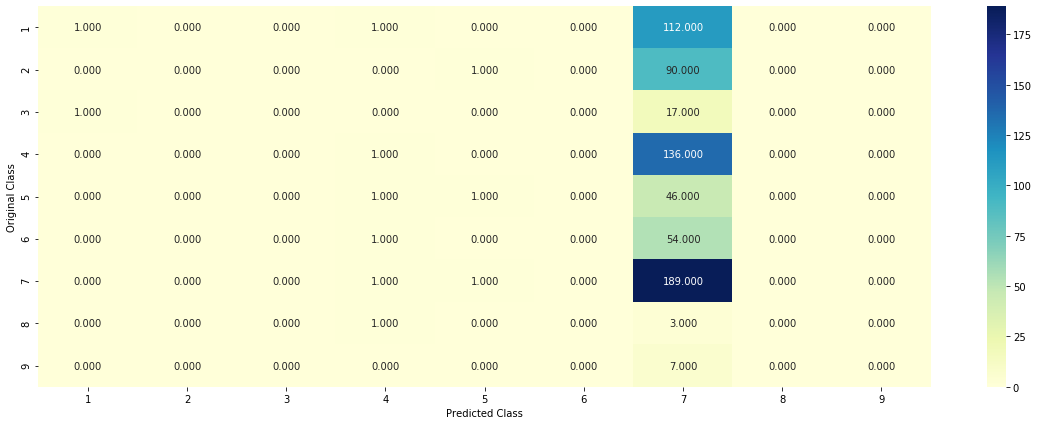

-------------------- Precision matrix (Columm Sum=1) --------------------


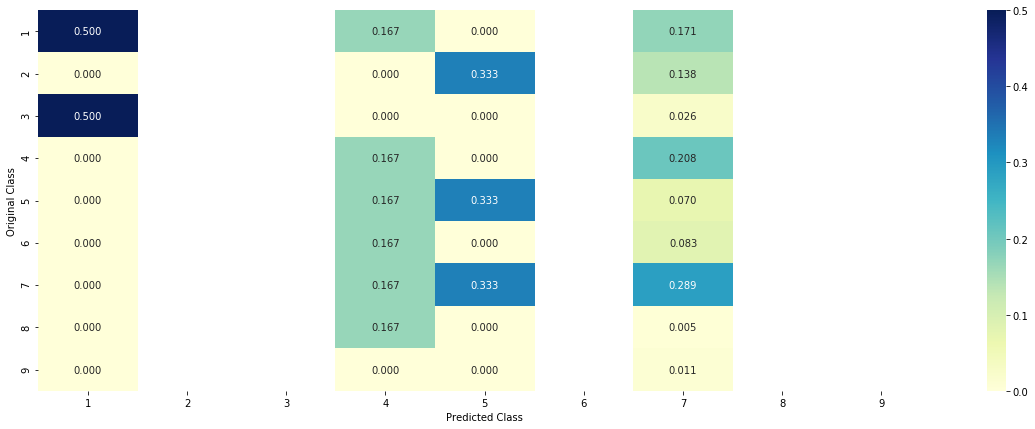

-------------------- Recall matrix (Row sum=1) --------------------


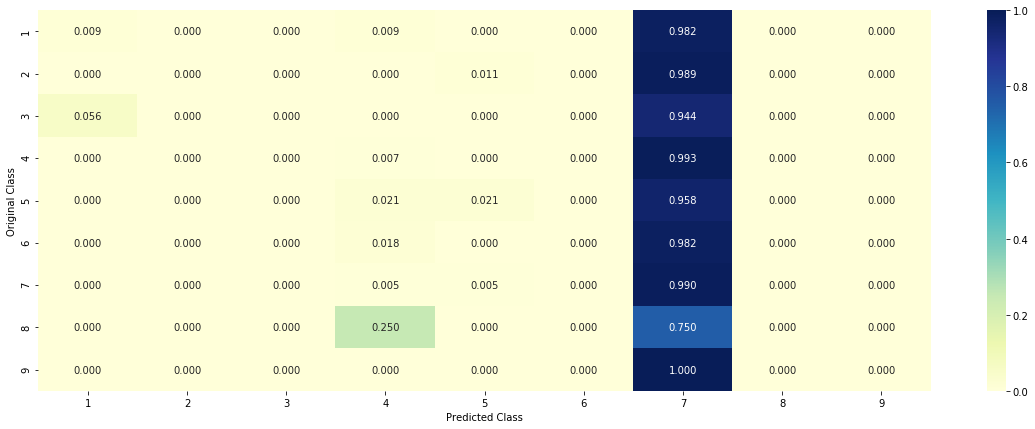

In [121]:
plot_confusion_matrix(y_test, y_pred)